# MAG analysis notebook

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from MAG import MicrosoftAcademicGraph
import os
from sparkhpc import sparkjob
import findspark
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('ggplot')

# set environment variables
os.environ["SPARK_LOCAL_DIRS"] = "/home/laal/MAG/TMP"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-1.8.0.242.b08-0.el7_7.x86_64"
os.environ['SPARK_HOME'] = "/home/laal/MAG/spark-3.0.2-bin-hadoop2.7"

In [2]:
def get_cluster_client(jobid, memory_per_executor=16000):
    sj = sparkjob.sparkjob(jobid=jobid, memory_per_executor=memory_per_executor)
    config_options = {
    "spark.memory.offHeap.enabled": True,
    "spark.memory.offHeap.size":"2g",
    "spark.sql.adaptive.enabled": True,
    "spark.sql.adaptive.coalescePartitions.enabled": True,
    "spark.sql.optimizer.dynamicPartitionPruning.reuseBroadcastOnly": False,
    "spark.shuffle.io.retryWait": "60s",
    "spark.reducer.maxReqsInFlight": 5,
    "spark.executor.memoryOverhead": "2gb",
    "spark.driver.memory": "20g",
    "spark.sql.shuffle.partitions": 300  
    }

    job = sj.start_spark(extra_conf = config_options)
    spark = SparkSession.builder.config(conf=job.getConf()).getOrCreate()
    return spark


def get_node_client(executor_memory="24g"):
    spark = SparkSession \
      .builder \
      .config("spark.executor.memory", executor_memory)\
      .config("spark.driver.memory", "2g")\
      .config("spark.executor.cores", 7)\
      .config("spark.memory.offHeap.enabled", True)\
      .config("spark.memory.offHeap.size","2g")\
      .config("spark.sql.adaptive.enabled", True)\
      .config("spark.sql.adaptive.coalescePartitions.enabled", True)\
      .config("spark.sql.optimizer.dynamicPartitionPruning.reuseBroadcastOnly", False)\
      .appName("MAG app") \
      .getOrCreate()
    return spark

In [3]:
spark = get_cluster_client(37432, memory_per_executor=14000)

['NAME STATE JOBID', 'sparkcluster RUNNING 37432', '3.train.small.5 RUNNING 37382', '3.train.small.4 RUNNING 37381', '3.train.small.3 RUNNING 37380', 'jupyter RUNNING 37433', 'main_job RUNNING 37414', '3.train.small.1 RUNNING 37378', '3.train.small.2 RUNNING 37379', '3.train.small.0 RUNNING 37377', '3.train.large.5 RUNNING 37376', '3.train.large.3 RUNNING 37375', '3.train.large.1 RUNNING 37374', '3.train.large.0 RUNNING 37368', '3.train.large.2 RUNNING 37370', '3.train.large.4 RUNNING 37372', 'agg RUNNING 37564', 'agg RUNNING 37563', 'agg RUNNING 37562', 'agg RUNNING 37561', 'agg RUNNING 37560', 'agg RUNNING 37431', 'agg RUNNING 37430', 'agg RUNNING 37429', 'agg RUNNING 37428', 'agg RUNNING 37427', 'agg RUNNING 37402', 'agg RUNNING 37401', 'agg RUNNING 37400', 'agg RUNNING 37399', 'agg RUNNING 37397', '']


In [4]:
mag = MicrosoftAcademicGraph(spark=spark, data_folderpath="/home/laal/MAG/DATA/")

In [6]:
def paper_field_of_study(mag):
    
    fos = mag.getDataframe('FieldsOfStudy')
    paper_fos = mag.getDataframe('PaperFieldsOfStudy')
    
    query = """
        SELECT 
        COUNT(DISTINCT(CASE WHEN fs.Level = 0 THEN pfs.PaperId ELSE null END)) as CountL0,
        COUNT(DISTINCT(pfs.PaperId)) as CountPapers
        FROM PaperFieldsOfStudy pfs
        LEFT JOIN FieldsOfStudy fs ON pfs.FieldOfStudyId = fs.FieldOfStudyId
    """

    paperfos = mag.query_sql(query)
    return paperfos

In [21]:
paper_fos_level_0 = paper_field_of_study(mag)
paper_fos_level_0_df = paper_fos_level_0.toPandas()

In [71]:
count_level0 = paper_fos_level_0_df.iloc[0]['CountL0']
count_all    =  paper_fos_level_0_df.iloc[0]['CountPapers']
print("{} / {} = {} % of papers have no level-0 discipline assigned. "
     .format(count_level0, count_all, (count_all-count_level0) / count_all))

NameError: name 'paper_fos_level_0_df' is not defined

In [25]:
def paper_root_field_mag(mag):
    
    fos = mag.getDataframe('FieldsOfStudy')
    paper_fos = mag.getDataframe('PaperRootField')
    
    query = """
        SELECT pfs.PaperId, fs.FieldOfStudyId
        FROM PaperFieldsOfStudy pfs
        INNER JOIN FieldsOfStudy fs ON pfs.FieldOfStudyId = fs.FieldOfStudyId
        WHERE fs.Level = 0
    """
    paper_fos = mag.query_sql(query)
    
    paper_fos.write.option("sep", "\t").option("encoding", "UTF-8")\
    .csv("/home/laal/MAG/DATA/PaperRootFieldMag.txt")
    
    return

In [26]:
paper_root_field_mag(mag)

In [6]:
def author_to_field_of_study(mag):
    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('WosToMag')
    paper_root_field = mag.getDataframe('PaperRootFieldMag')

    query = """
    SELECT paa.AuthorId, 
           prf.AncestorId,
           COUNT(*) AS NumPapersInField
    FROM PaperAuthorAffiliations AS paa
    INNER JOIN WosToMag AS wtm ON paa.AuthorId = wtm.MAG 
    INNER JOIN PaperRootFieldMag AS prf ON paa.PaperId = prf.PaperId
    GROUP BY paa.AuthorId, 
             prf.AncestorId
    ORDER BY COUNT(*) DESC
    LIMIT 1000
    """
    author_to_field = mag.query_sql(query)
    return author_to_field

In [35]:
def gender_per_discipline_per_year(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('WosToMag')
    paper_root_field = mag.getDataframe('PaperRootFieldMag')
    author_country = mag.getDataframe('AuthorCountry')
    papers = mag.getDataframe('Papers')
    
    query = """
    SELECT 
    YEAR(p.Date), prf.FieldOfStudyId, wtm.Gender, COUNT(paa.PaperId) as Authorships
    FROM PaperAuthorAffiliations paa 
    INNER JOIN WosToMag wtm ON paa.AuthorId = wtm.MAG
    INNER JOIN Papers p ON paa.PaperId = p.PaperId
    INNER JOIN PaperRootFieldMag prf ON paa.PaperId = prf.PaperId
    WHERE wtm.Gender IN (0, 1)
    GROUP BY YEAR(p.Date), wtm.Gender, prf.FieldOfStudyId
    """
    gender_per_discipline = mag.query_sql(query)
    return gender_per_discipline

In [36]:
gender_per_discipline = gender_per_discipline_per_year(mag)
gender_per_discipline_df = gender_per_discipline.toPandas()

In [37]:
filtered = gender_per_discipline_df.sort_values(by=['FieldOfStudyId', 'year(Date)'])
filtered = filtered[(filtered['year(Date)'] > 1950) & (filtered['year(Date)'] < 2021)]

In [99]:
gender_per_discipline_df.to_csv('MAG_FILES/AuthorshipsPerYearFieldAndGender.csv', index=False)

In [4]:
fos_df = pd.read_csv('MAG_FILES/field_of_study.csv')
# extract level 0
fos_df = fos_df.query("Level == 0")

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


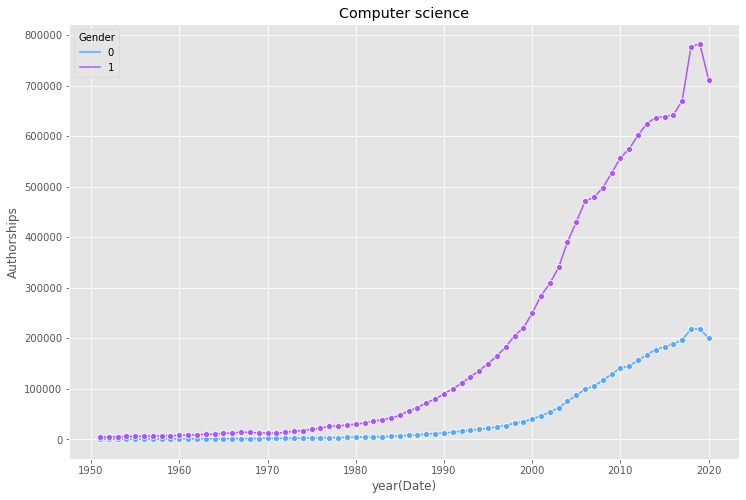

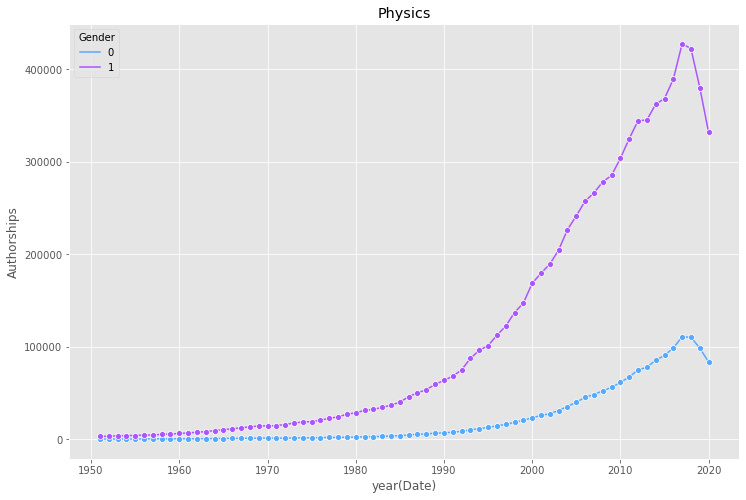

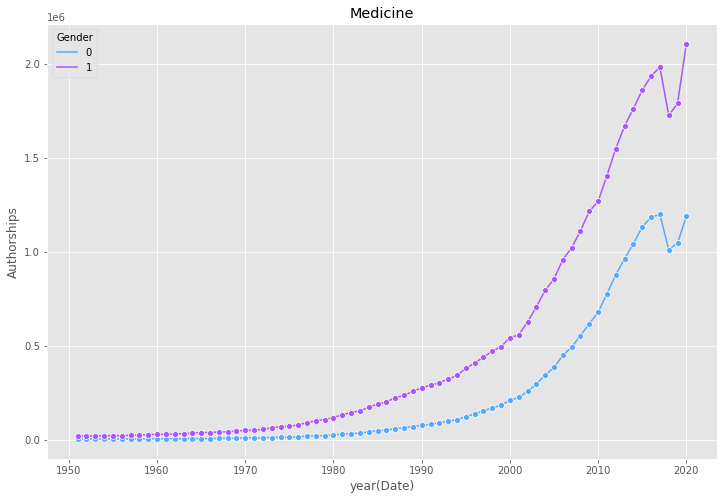

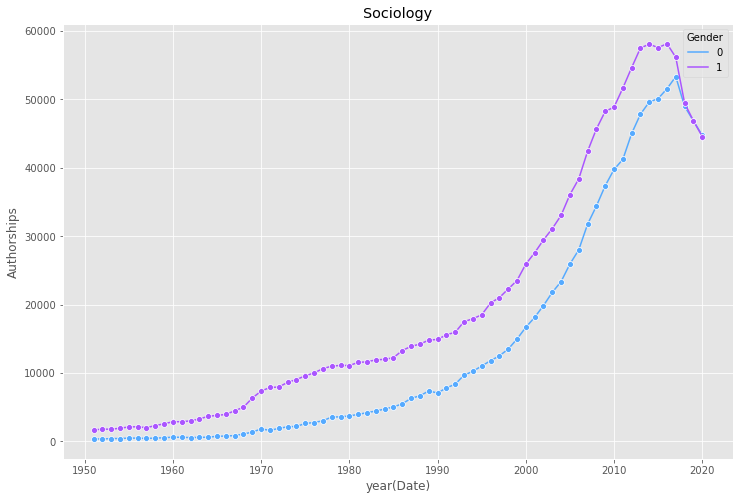

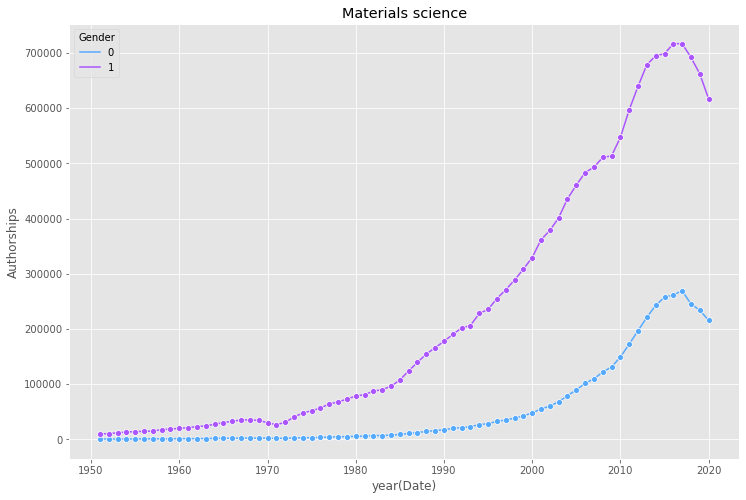

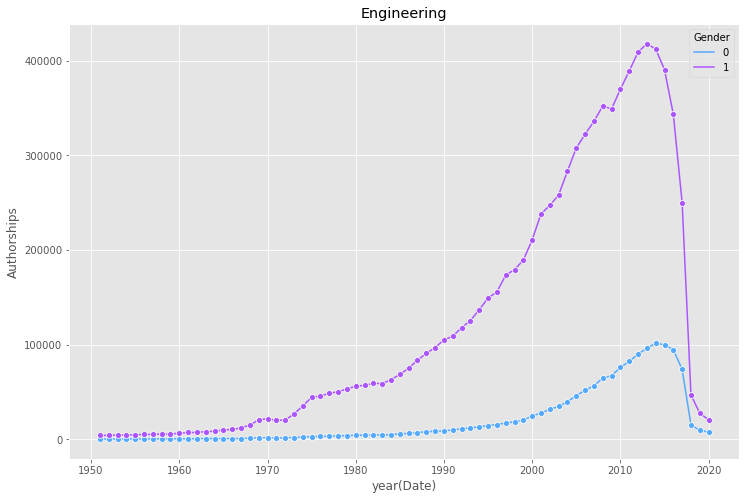

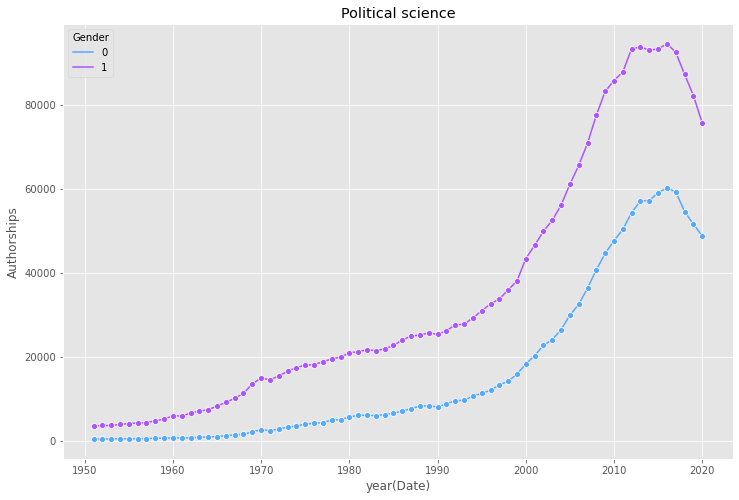

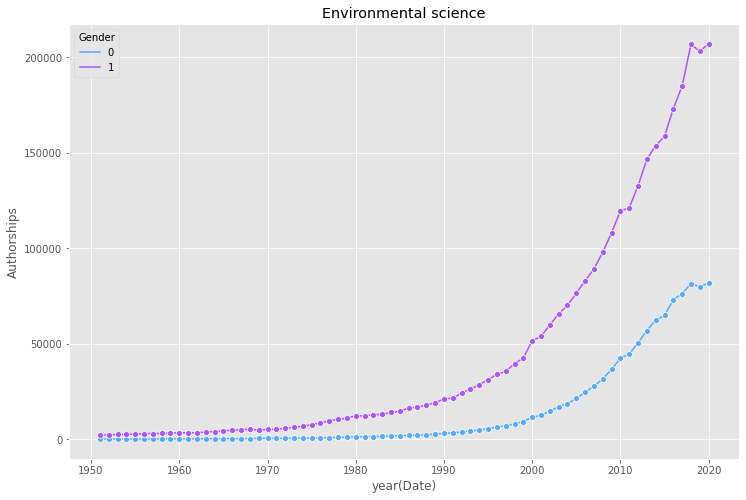

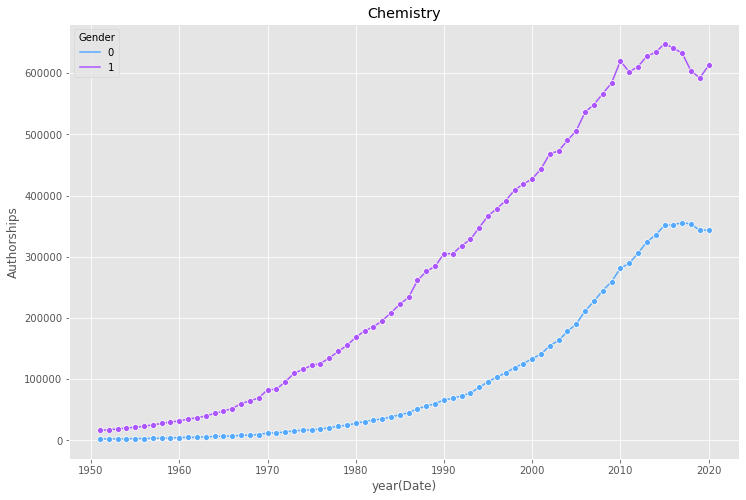

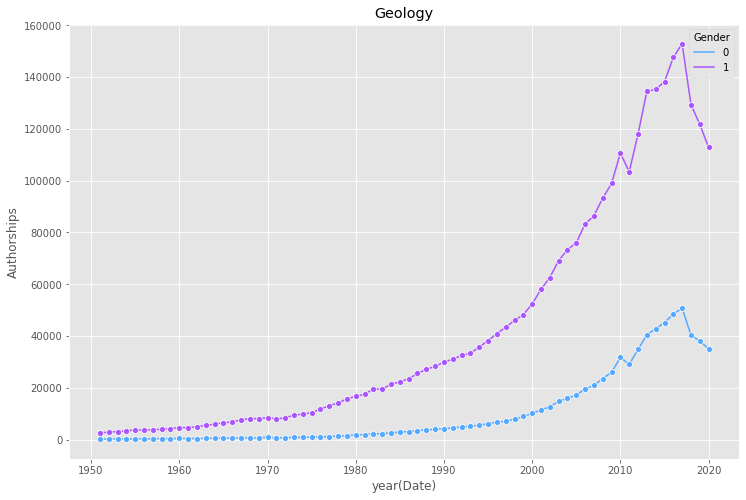

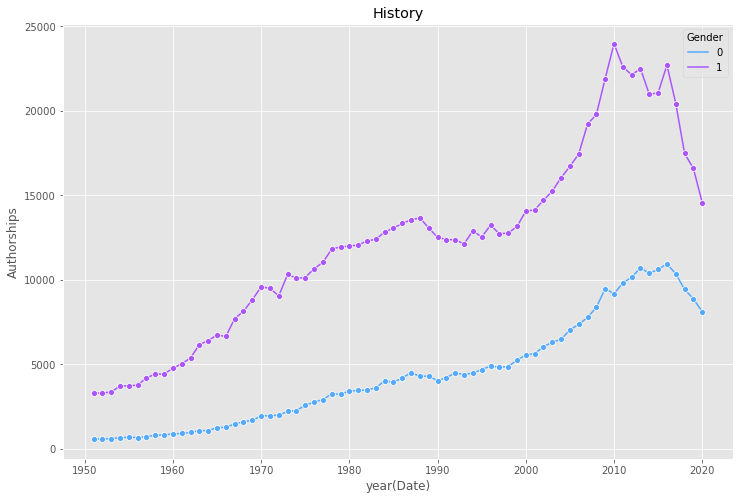

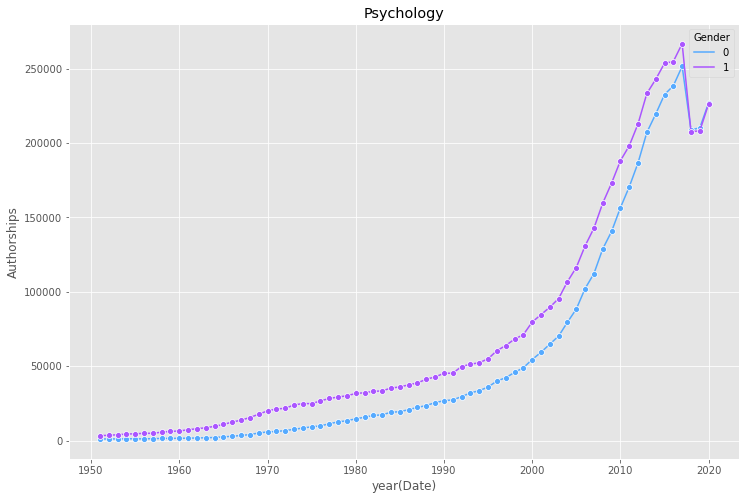

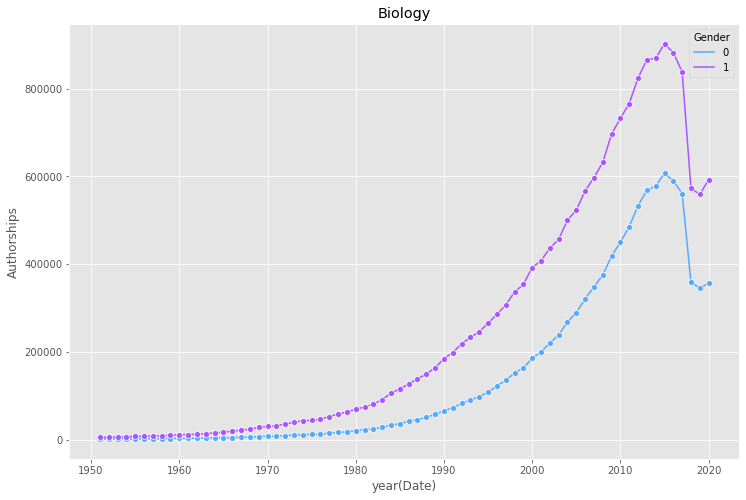

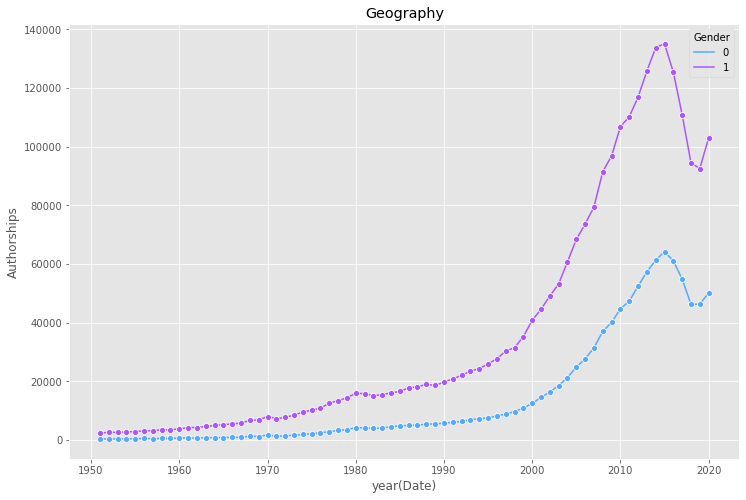

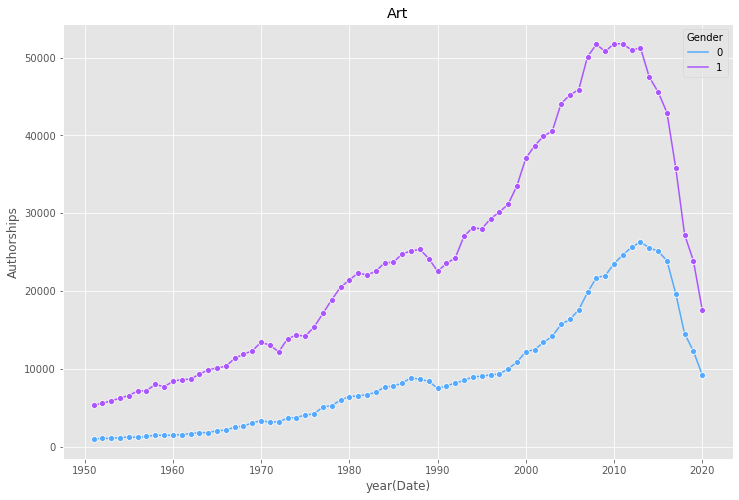

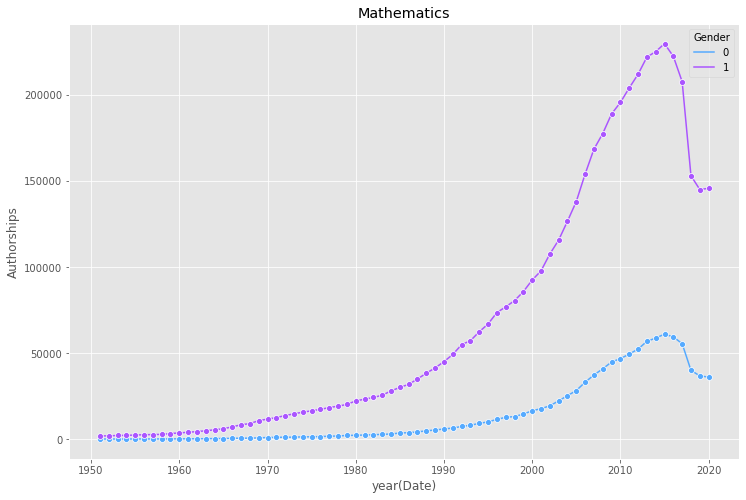

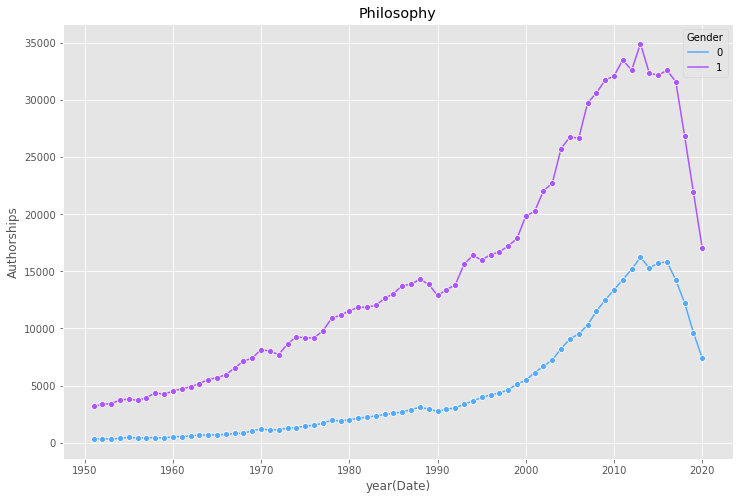

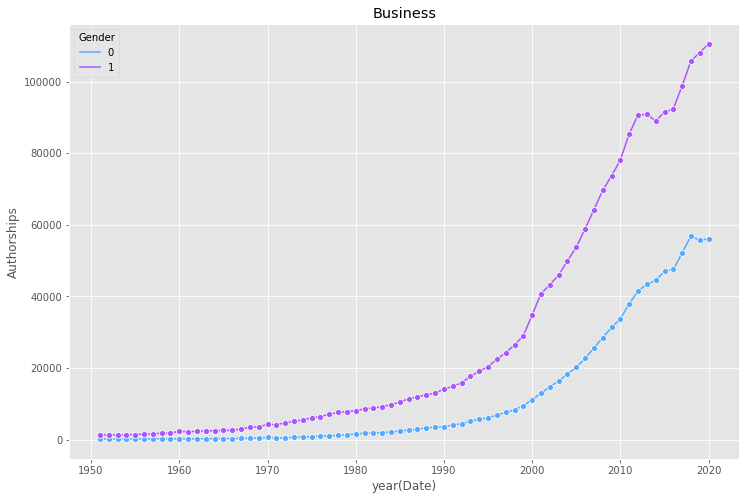

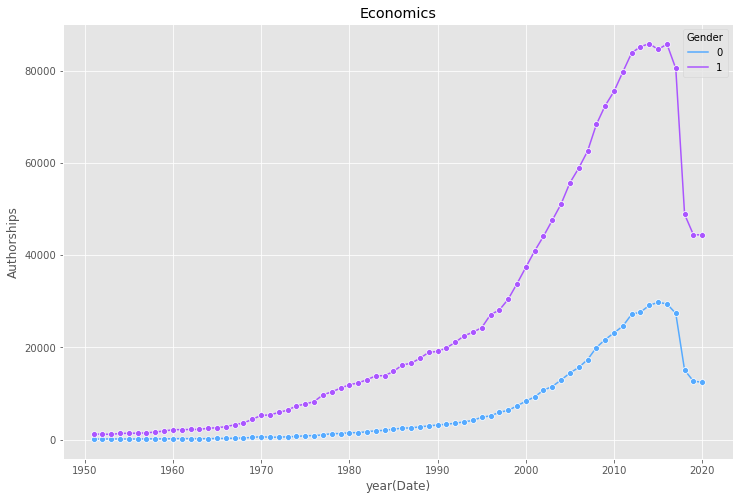

In [78]:
for record in fos_df.to_dict('records'):
    fig, ax = plt.subplots(figsize=(12,8))
    sns.lineplot(data=filtered[filtered.FieldOfStudyId==record['FieldOfStudyId']], 
                 x='year(Date)', y='Authorships', hue='Gender', marker="o",
                 palette='cool').set_title(record['DisplayName'])


In [16]:
def gender_per_discipline_per_year_with_unknown(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliationsGendered')
    paper_root_field = mag.getDataframe('PaperRootFieldMag')
    papers = mag.getDataframe('Papers')
    
    query = """
    SELECT 
    YEAR(p.Date) as Year, prf.FieldOfStudyId, paag.Gender, COUNT(paag.PaperId) as Authorships
    FROM PaperAuthorAffiliationsGendered paag 
    INNER JOIN Papers p ON paag.PaperId = p.PaperId
    INNER JOIN PaperRootFieldMag prf ON paag.PaperId = prf.PaperId
    GROUP BY YEAR(p.Date), paag.Gender, prf.FieldOfStudyId
    """
    gender_per_discipline = mag.query_sql(query)
    return gender_per_discipline

In [17]:
authorships_per_year = gender_per_discipline_per_year_with_unknown(mag)

In [18]:
authorships_per_year_df = authorships_per_year.toPandas()

In [19]:
filtered = authorships_per_year_df.sort_values(by=['FieldOfStudyId', 'Year'])
filtered = filtered[(filtered['Year'] > 1950) & (filtered['Year'] < 2021)]

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


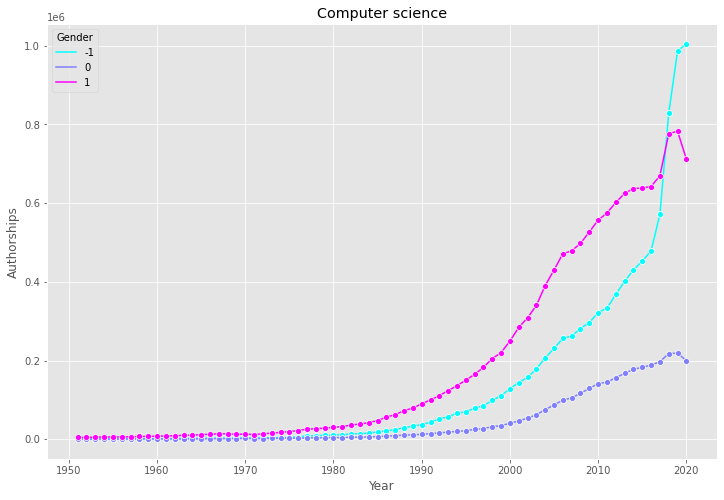

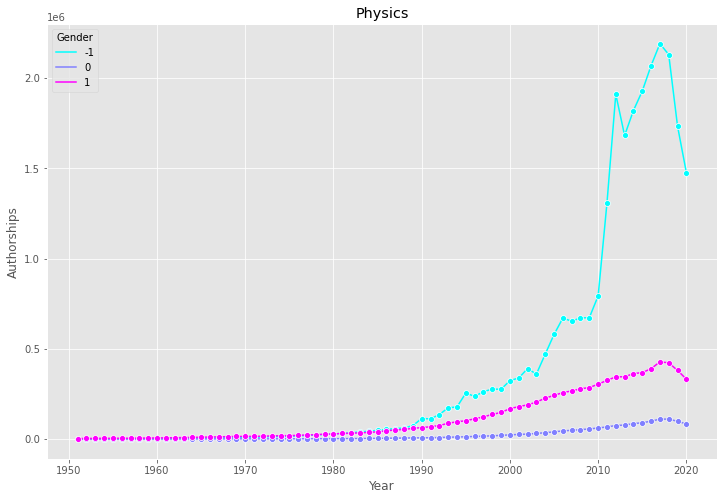

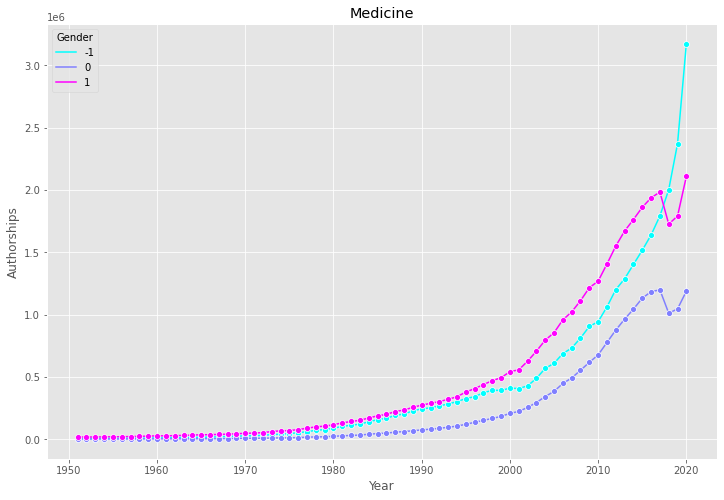

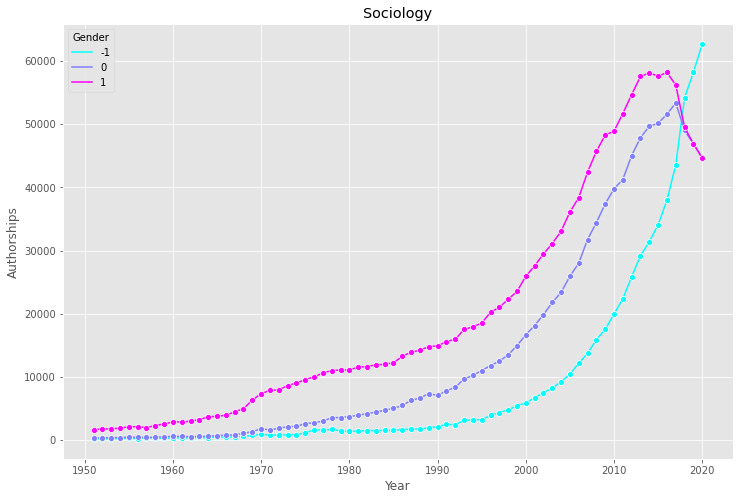

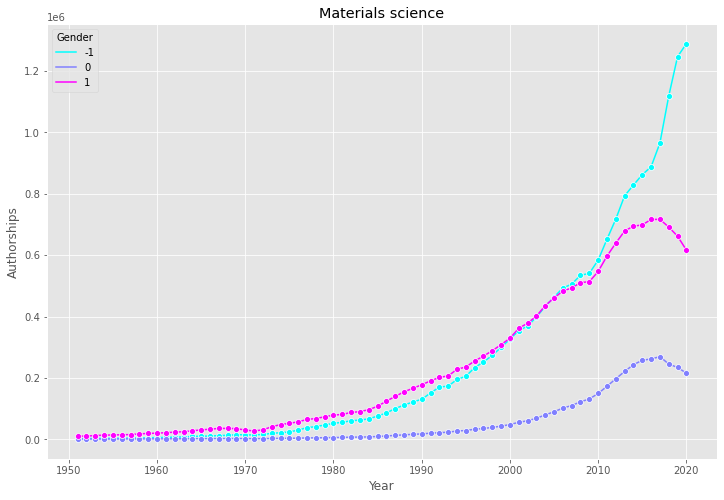

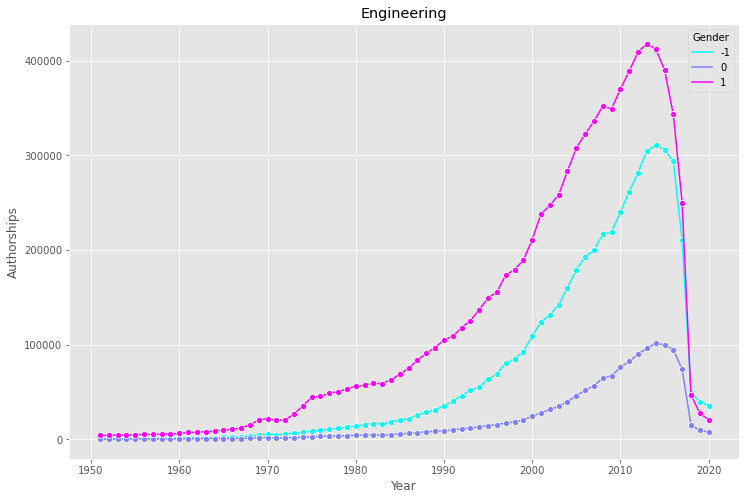

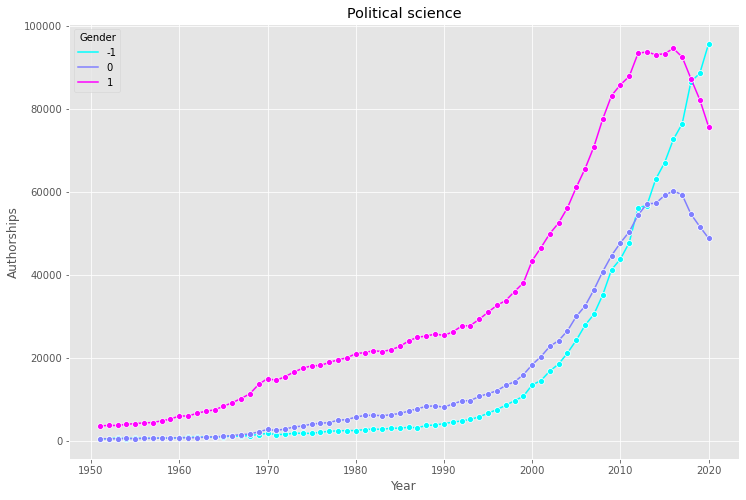

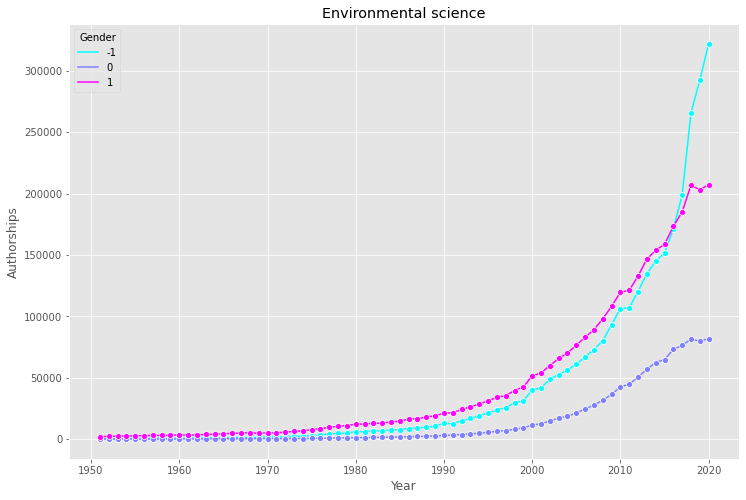

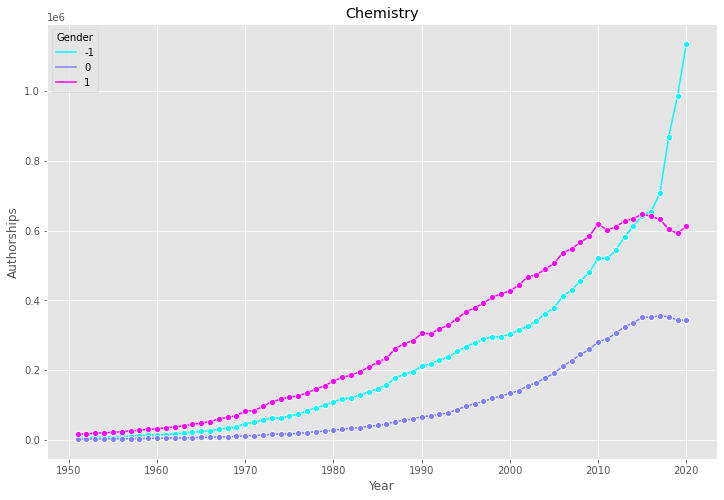

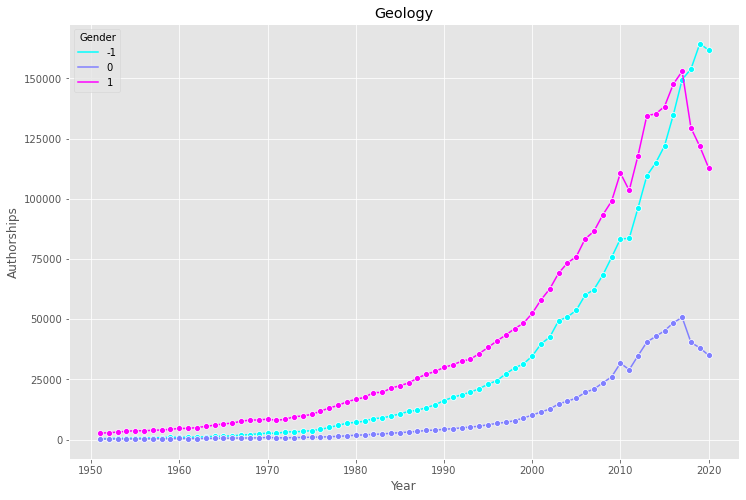

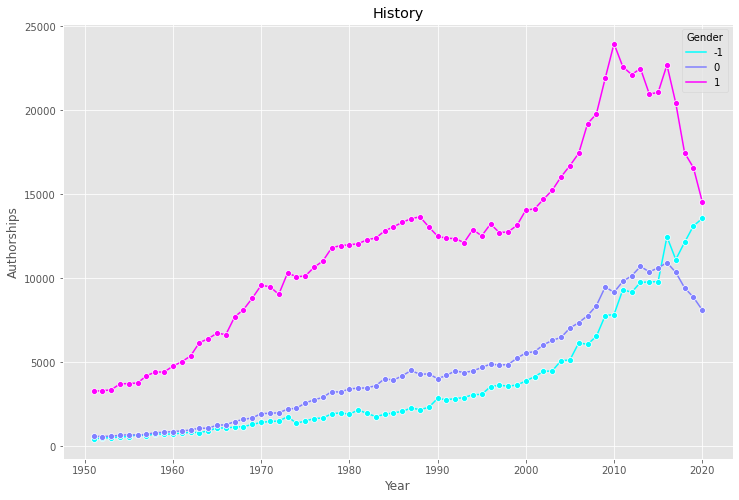

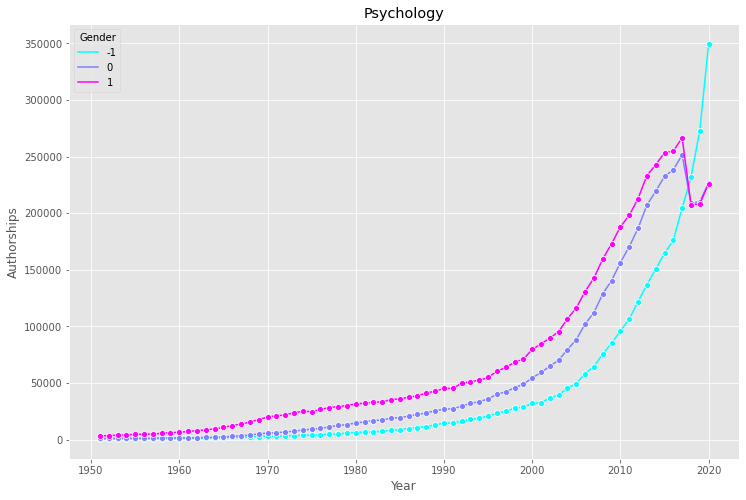

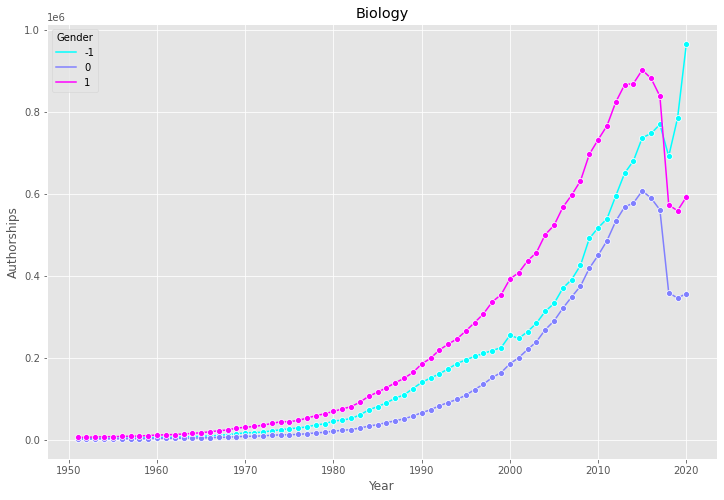

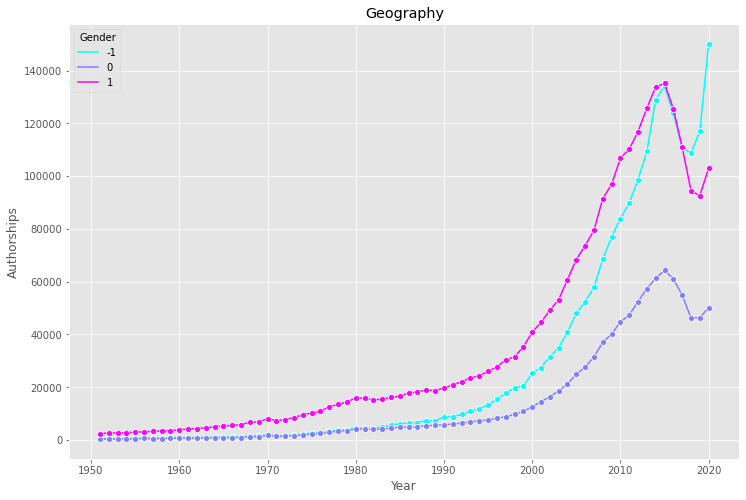

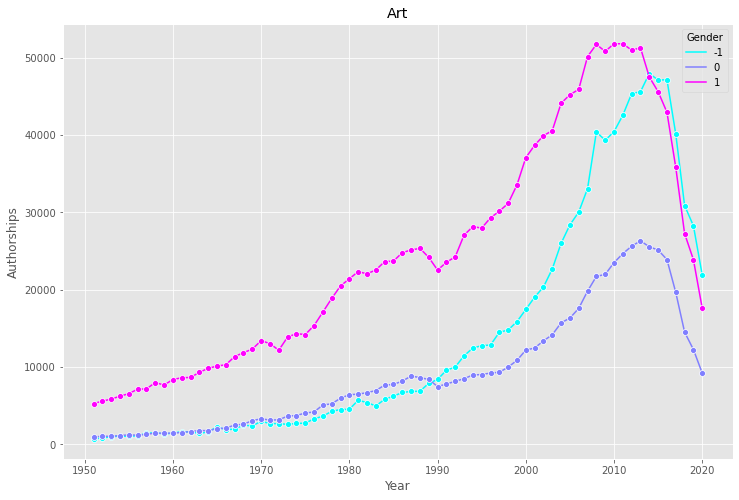

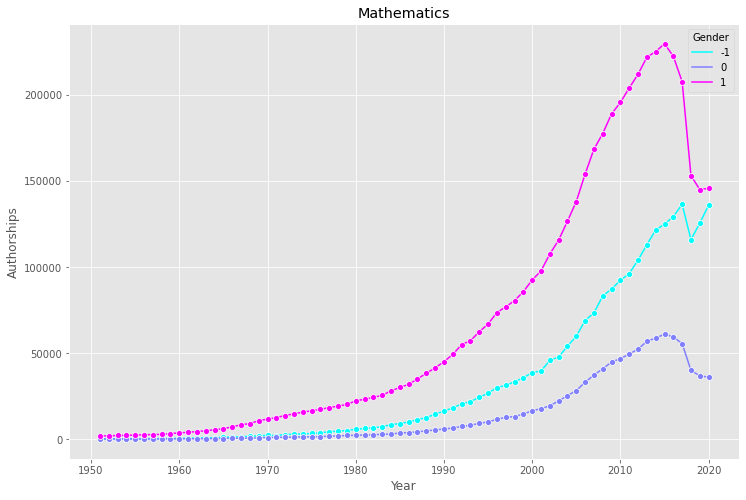

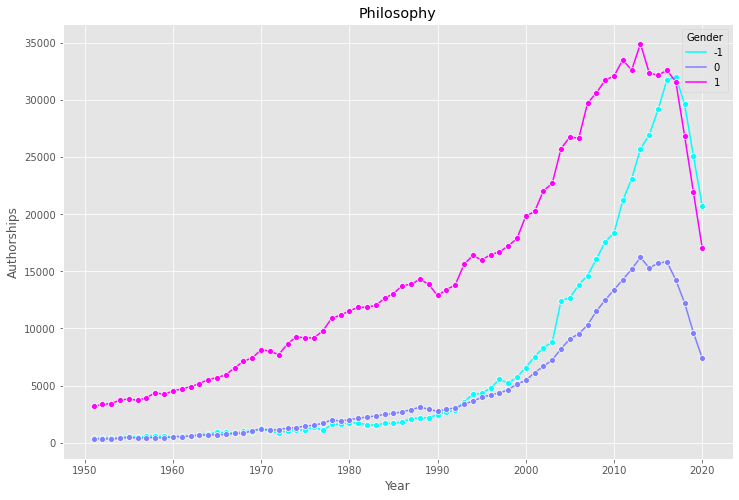

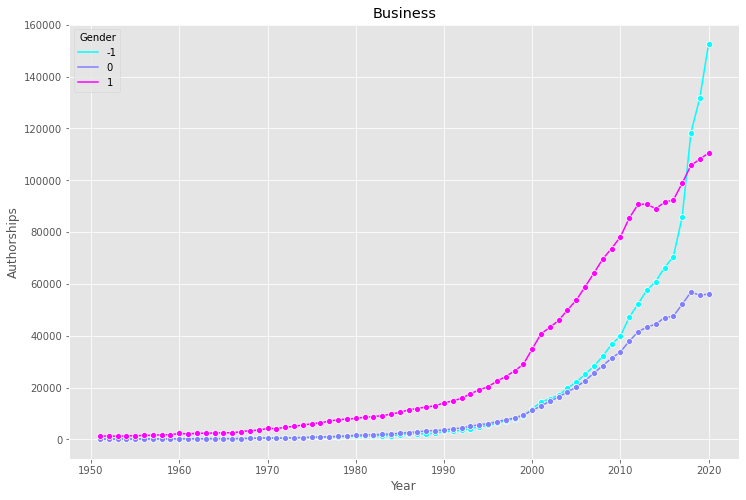

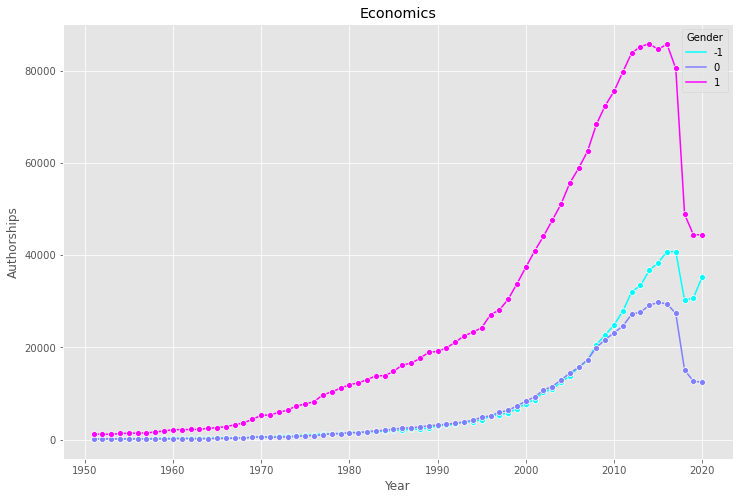

In [22]:
for record in fos_df.to_dict('records'):
    fig, ax = plt.subplots(figsize=(12,8))
    sns.lineplot(data=filtered[filtered.FieldOfStudyId==record['FieldOfStudyId']], 
                 x='Year', y='Authorships', hue='Gender', marker="o",
                 palette='cool').set_title(record['DisplayName'])

In [25]:
plt.rcParams.update({'figure.max_open_warning': 0})

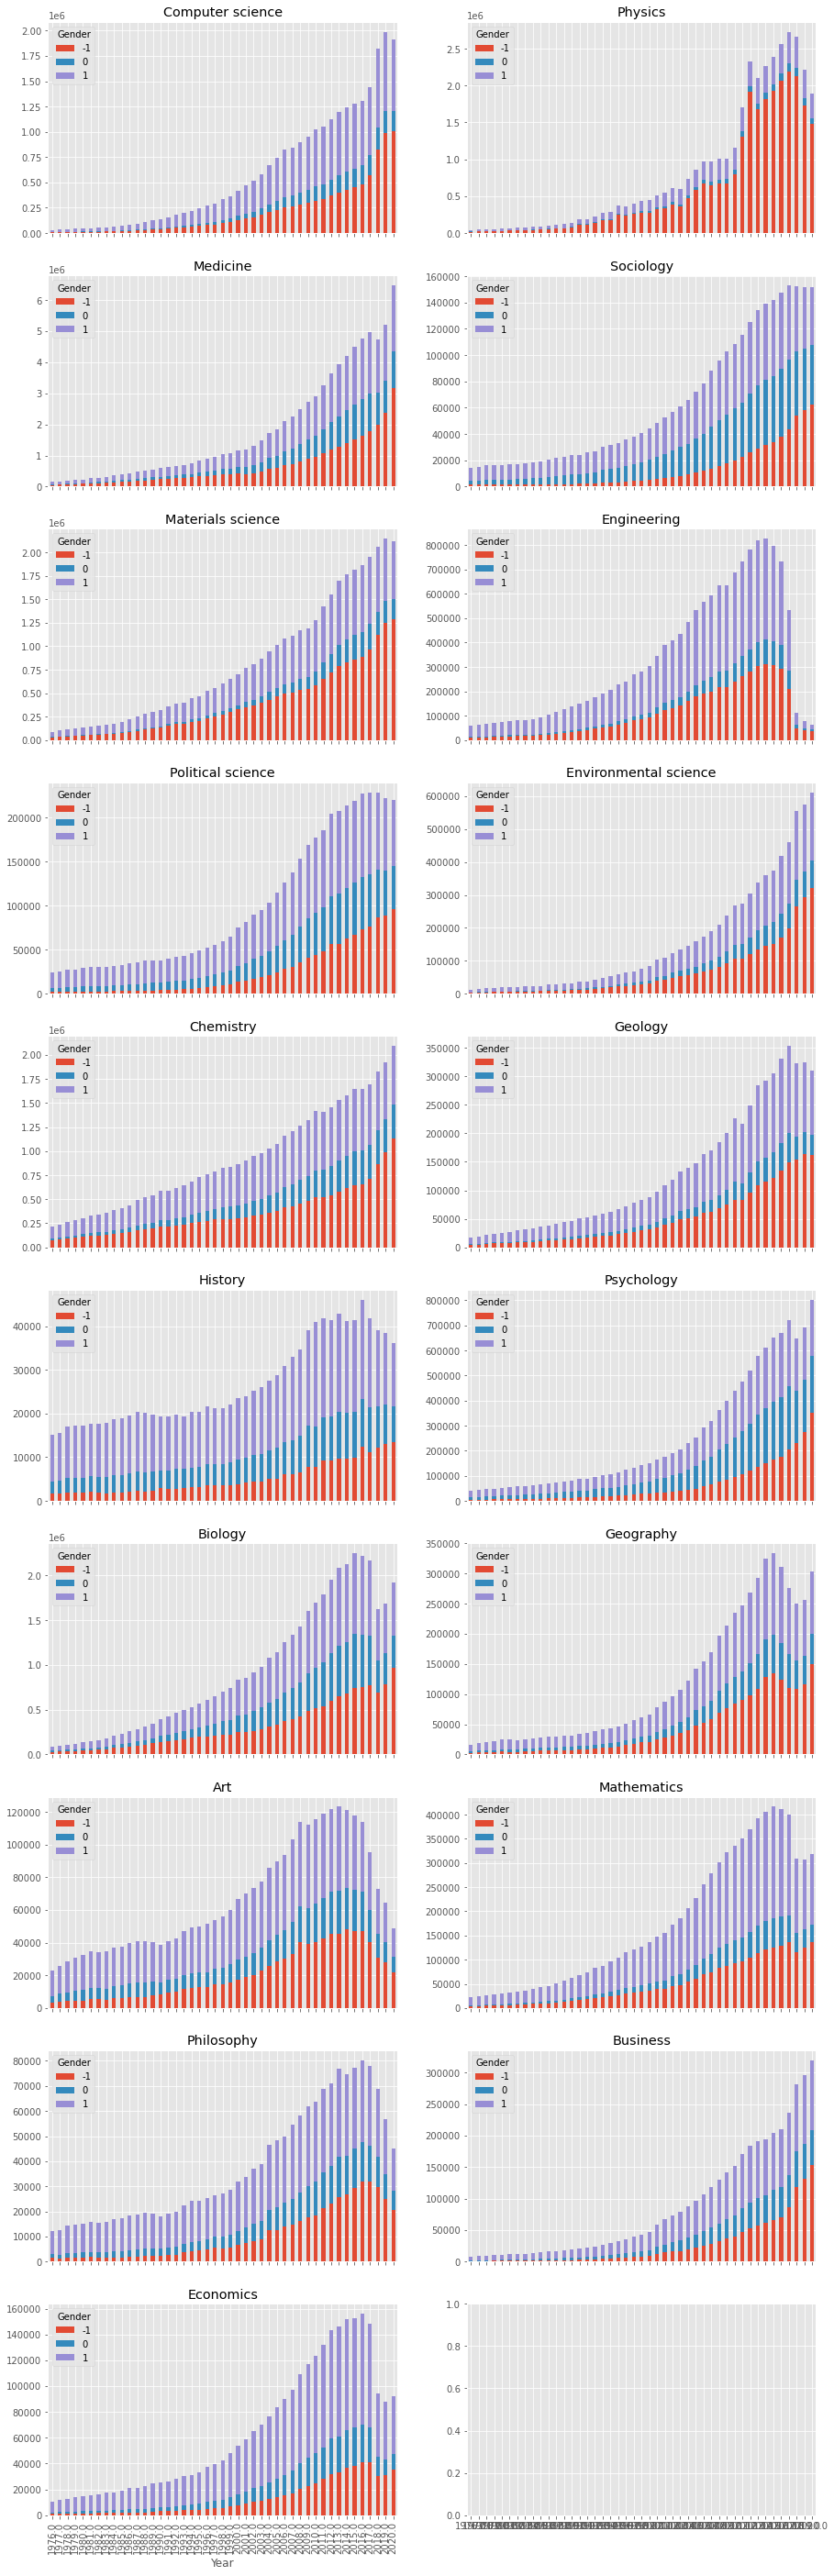

In [36]:
idx = 0
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(15,50), sharex=True)
axs = list(axs.flatten())


for record in fos_df.to_dict('records'):
    
    filtered_data = filtered[filtered.FieldOfStudyId==record['FieldOfStudyId']]
    filtered_data = filtered_data[filtered_data.Year > 1975]
    filtered_pivot = filtered_data.pivot(index='Year', columns='Gender', values='Authorships')
    
    filtered_pivot.plot.bar(stacked=True, ax=axs[idx])
    axs[idx].set_title(record['DisplayName'])
    # plt.show()
    idx += 1
    

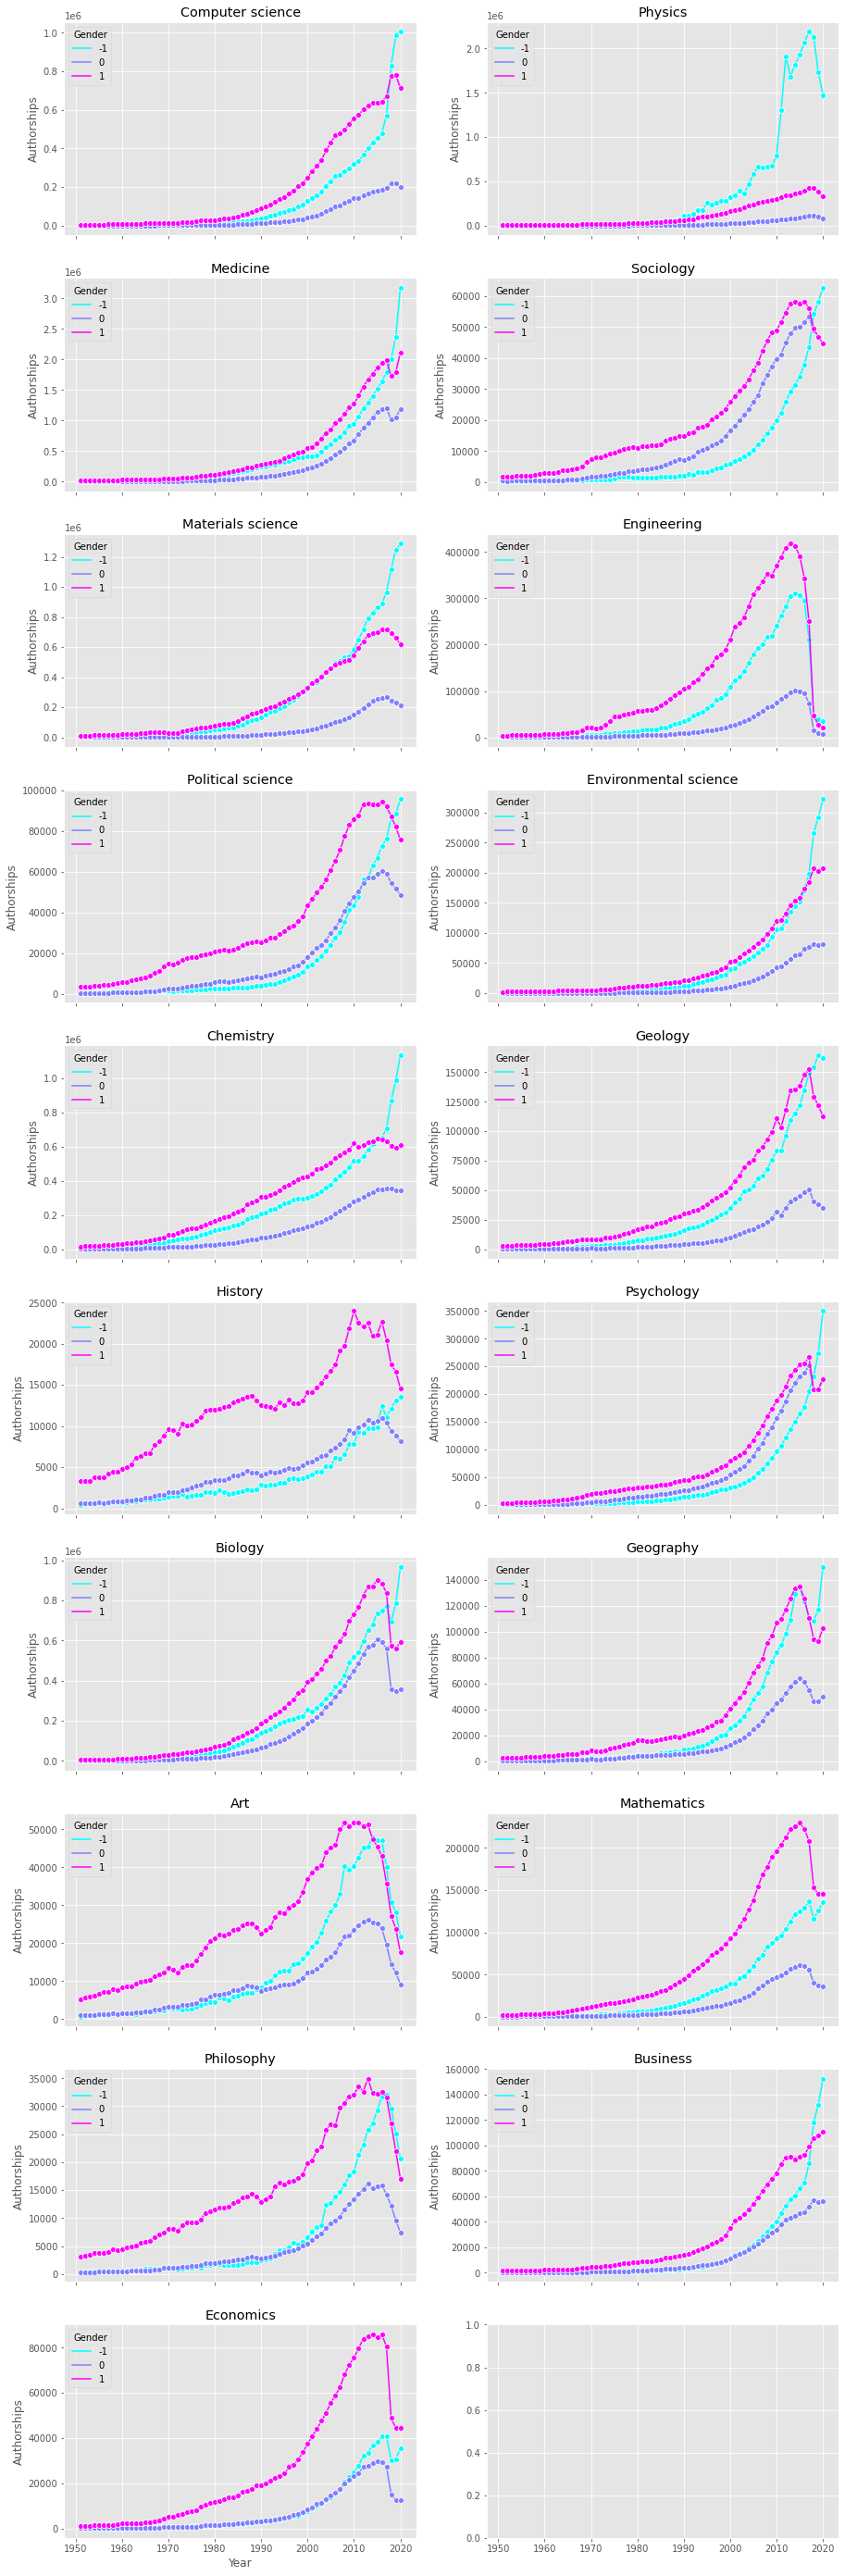

In [38]:
idx = 0
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(15,50), sharex=True)
axs = list(axs.flatten())


for record in fos_df.to_dict('records'):
    sns.lineplot(data=filtered[filtered.FieldOfStudyId==record['FieldOfStudyId']], 
                 x='Year', y='Authorships', hue='Gender', marker="o",
                 palette='cool', ax=axs[idx]).set_title(record['DisplayName'])
    
    idx += 1

In [27]:
gender_per_discipline_df.to_csv("MAG_FILES/AuthorshipsPerGenderAndField.csv", index=False)

In [31]:
def authorships_per_year(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('WosToMag')
    papers = mag.getDataframe('Papers')
    paper_field = mag.getDataframe('PaperRootFieldMag')
    
    query = """
    SELECT 
    YEAR(p.Date), 
    prf.FieldOfStudyId, 
    COUNT(paa.PaperId) as AllAuthorships,
    COUNT(CASE WHEN wtm.Gender IN (0, 1) THEN paa.PaperId ELSE null END) as WosAuthorships
    FROM PaperAuthorAffiliations paa 
    INNER JOIN Papers p ON paa.PaperId = p.PaperId
    INNER JOIN PaperRootFieldMag prf ON paa.PaperId = prf.PaperId
    LEFT JOIN WosToMag wtm ON paa.AuthorId = wtm.MAG
    GROUP BY YEAR(p.Date), prf.FieldOfStudyId
    """
    authorships_per_anno = mag.query_sql(query)
    return authorships_per_anno

In [32]:
authorships_per_anno = authorships_per_year(mag)

In [34]:
authorships_per_anno_df = authorships_per_anno.toPandas()

In [98]:
authorships_per_anno_df.to_csv('MAG_FILES/AuthorshipsPerYear.csv', index=False)

In [61]:
authorships_per_anno_df_group  = authorships_per_anno_df.groupby('year(Date)')\
.sum(['AllAuthorships', 'WosAuthorships']).reset_index()

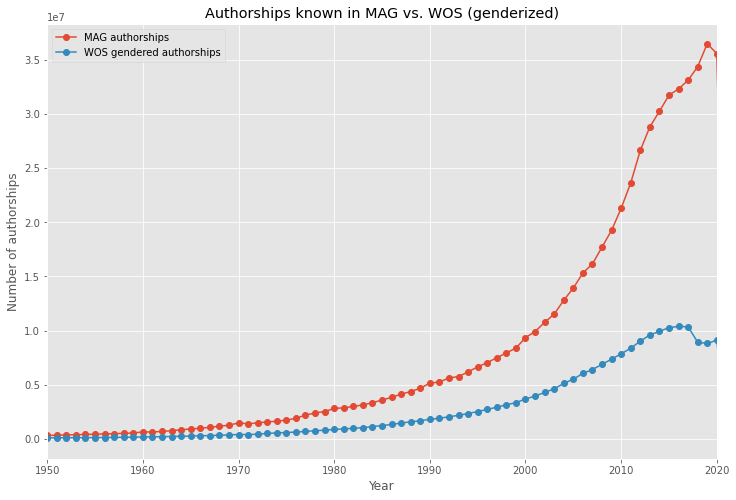

In [70]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(authorships_per_anno_df_group['year(Date)'],  authorships_per_anno_df_group['AllAuthorships'], '-o', label='MAG authorships')
plt.plot(authorships_per_anno_df_group['year(Date)'],  authorships_per_anno_df_group['WosAuthorships'], '-o', label='WOS gendered authorships')
plt.xlim(1950, 2020)
plt.title('Authorships known in MAG vs. WOS (genderized)')
plt.xlabel('Year')
plt.ylabel('Number of authorships')
plt.legend()
plt.show()

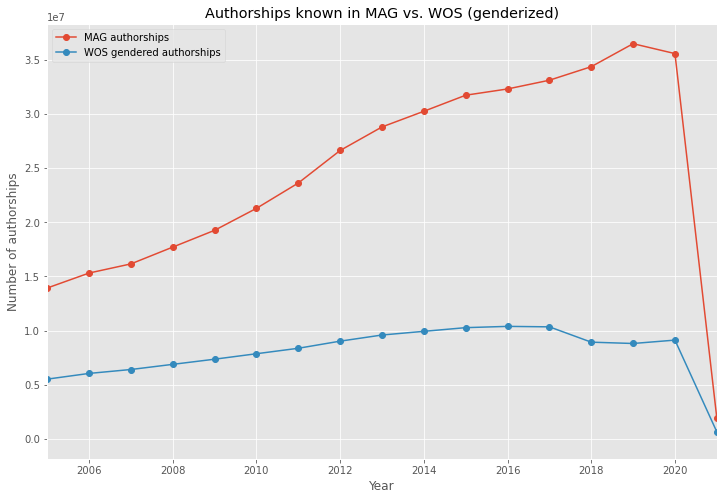

In [68]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(authorships_per_anno_df_group['year(Date)'],  authorships_per_anno_df_group['AllAuthorships'], 
         '-o', label='MAG authorships')
plt.plot(authorships_per_anno_df_group['year(Date)'],  authorships_per_anno_df_group['WosAuthorships'], 
         '-o', label='WOS gendered authorships')
plt.xlim(2005, 2021)
plt.title('Authorships known in MAG vs. WOS (genderized)')
plt.xlabel('Year')
plt.ylabel('Number of authorships')
plt.legend()
plt.show()

### Interdisciplinary citations

In [7]:
def citations_by_discipline(mag):
    
    paper_references = mag.getDataframe('PaperReferences')
    paper_field = mag.getDataframe('PaperRootFieldMag')
    
    query = """
        SELECT 
        prf1.FieldOfStudyId as CitingField,
        prf2.FieldOfStudyId as CitedField,
        COUNT(DISTINCT(pr.PaperId)) as NumCitingPapers,
        COUNT(pr.PaperReferenceId) as NumCitedPapers
        FROM PaperReferences pr
        INNER JOIN PaperRootFieldMag prf1 ON pr.PaperId = prf1.PaperId
        INNER JOIN PaperRootFieldMag prf2 ON pr.PaperReferenceId = prf2.PaperId
        GROUP BY prf1.FieldOfStudyId, prf2.FieldOfStudyId
    """
    
    discipline_citations = mag.query_sql(query)
    return discipline_citations

In [8]:
discipline_citations = citations_by_discipline(mag)
discipline_citations_df = discipline_citations.toPandas()

In [85]:
discipline_citations_df.sort_values(by='CitingField')

,CitingField,CitedField,NumCitingPapers,NumCitedPapers
16,15744967,127413603,856377,856377
150,15744967,15744967,65928454,65928454
18,15744967,127313418,30285,30285
140,15744967,138885662,669959,669959
279,15744967,86803240,4101102,4101102
...,...,...,...,...
101,205649164,121332964,211485,211485
234,205649164,71924100,1068758,1068758
158,205649164,142362112,274451,274451
74,205649164,162324750,1060349,1060349


In [89]:
citing_field_sums = discipline_citations_df.groupby('CitingField').sum().to_dict('index')

In [93]:
discipline_citations_df['CitationRate'] = discipline_citations_df.apply(lambda x: x['NumCitedPapers'] / citing_field_sums[x['CitingField']]['NumCitedPapers'], axis=1)
discipline_citations_df.sort_values(by='CitationRate', ascending=False)

,CitingField,CitedField,NumCitingPapers,NumCitedPapers,CitationRate
268,86803240,86803240,215154615,215154615,0.743269
205,71924100,71924100,223459418,223459418,0.720664
168,121332964,121332964,54164211,54164211,0.686308
150,15744967,15744967,65928454,65928454,0.628908
198,127313418,127313418,23049185,23049185,0.626461
...,...,...,...,...,...
221,192562407,162324750,21968,21968,0.000124
43,192562407,17744445,19846,19846,0.000112
147,192562407,95457728,15241,15241,0.000086
119,185592680,144024400,17334,17334,0.000080


In [94]:
discipline_citations_df.to_csv('MAG_FILES/CitationsByDiscipline.csv', index=False)

In [6]:
def citations_by_year(mag):
    
    paper_references = mag.getDataframe('PaperReferences')
    paper_field = mag.getDataframe('PaperRootFieldMag')
    papers = mag.getDataframe('Papers')
    
    query = """
        SELECT 
        prf1.FieldOfStudyId as CitingField,
        prf2.FieldOfStudyId as CitedField,
        YEAR(p1.Date) as CitingYear,
        YEAR(p2.Date) as CitedYear,
        COUNT(pr.PaperId) as NumCitingPapers,
        COUNT(pr.PaperReferenceId) as NumCitedPapers
        FROM PaperReferences pr
        INNER JOIN PaperRootFieldMag prf1 ON pr.PaperId = prf1.PaperId
        INNER JOIN PaperRootFieldMag prf2 ON pr.PaperReferenceId = prf2.PaperId
        INNER JOIN Papers p1 ON pr.PaperId = p1.PaperId
        INNER JOIN Papers p2 ON pr.PaperReferenceId = p2.PaperId
        GROUP BY prf1.FieldOfStudyId, prf2.FieldOfStudyId, YEAR(p1.Date), YEAR(p2.Date)
    """
    
    discipline_citations = mag.query_sql(query)
    return discipline_citations

In [7]:
citations_by_year_and_field = citations_by_year(mag)

In [8]:
citations_by_year_and_field_df = citations_by_year_and_field.toPandas()

In [11]:
citations_by_year_and_field_df

,CitingField,CitedField,CitingYear,CitedYear,NumCitingPapers,NumCitedPapers
0,41008148,127413603,1987.0,1954.0,25,25
1,86803240,86803240,2014.0,2013.0,766224,766224
2,41008148,185592680,2003.0,1994.0,1063,1063
3,71924100,185592680,2007.0,1994.0,13999,13999
4,15744967,71924100,2015.0,2009.0,53481,53481
...,...,...,...,...,...,...
2578904,71924100,185592680,1960.0,1870.0,1,1
2578905,17744445,192562407,2009.0,1904.0,1,1
2578906,127313418,192562407,1965.0,2004.0,1,1
2578907,41008148,162324750,2015.0,1913.0,4,4


In [12]:
citations_by_year_and_field_df.to_csv('MAG_FILES/CitationsByDisciplineAndYear.csv', index=False)

In [16]:
citations_by_year = citations_by_year_and_field_df\
.groupby(['CitingYear', 'CitedYear'])\
['NumCitingPapers', 'NumCitedPapers'].sum().reset_index()

/home/laal/.conda/envs/torchenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
citations_by_year.to_csv('MAG_FILES/CitationsByYear.csv', index=False)

In [49]:
def citations_by_discipline_and_year(mag, out=False):
    
    paper_references = mag.getDataframe('PaperReferences')
    paper_field = mag.getDataframe('PaperRootFieldMag')
    papers = mag.getDataframe('Papers')
    
    if out:
        query = """
            SELECT 
            YEAR(p.Date) as Year,
            prf1.FieldOfStudyId as CitingField,
            COUNT(pr.PaperId) as NumOutgoingCitations
            FROM PaperReferences pr
            INNER JOIN PaperRootFieldMag prf1 ON pr.PaperId = prf1.PaperId
            INNER JOIN Papers p ON pr.PaperId = p.PaperId
            GROUP BY YEAR(p.Date), prf1.FieldOfStudyId
        """
        discipline_citations = mag.query_sql(query)
    else: 
        query = """
            SELECT 
            YEAR(p.Date) as Year,
            prf1.FieldOfStudyId as CitedField,
            COUNT(pr.PaperReferenceId) as NumIncomingCitations
            FROM PaperReferences pr
            INNER JOIN PaperRootFieldMag prf1 ON pr.PaperReferenceId = prf1.PaperId
            INNER JOIN Papers p ON pr.PaperReferenceId = p.PaperId
            GROUP BY YEAR(p.Date), prf1.FieldOfStudyId
        """
        discipline_citations = mag.query_sql(query)
        
    return discipline_citations


In [44]:
discipline_citations_out = citations_by_discipline_and_year(mag, out=True).toPandas()

In [50]:
discipline_citations_in = citations_by_discipline_and_year(mag, out=False).toPandas()

In [51]:
discipline_citations_in

,Year,CitedField,NumIncomingCitations
0,1997.0,127413603,2411578
1,2003.0,39432304,1102582
2,1991.0,95457728,135079
3,1962.0,71924100,515878
4,1948.0,185592680,231511
...,...,...,...
4208,1869.0,144133560,9
4209,1825.0,162324750,4
4210,1814.0,162324750,1
4211,1821.0,144133560,1


In [54]:
discipline_cites = pd.merge(discipline_citations_out, discipline_citations_in, 
                            left_on=['Year', 'CitingField'], 
                            right_on=['Year', 'CitedField'])

In [56]:
discipline_cites.to_csv('MAG_FILES/PaperCitationsIngoingOutgoingPerYear.csv', index=False)

In [2]:
discipline_cites = pd.read_csv('MAG_FILES/PaperCitationsIngoingOutgoingPerYear.csv')

In [3]:
discipline_cites

,Year,CitingField,NumOutgoingCitations,CitedField,NumIncomingCitations
0,1997.0,127413603,1069733,127413603,2411578
1,2003.0,39432304,550886,39432304,1102582
2,1962.0,71924100,170119,71924100,515878
3,1991.0,95457728,45695,95457728,135079
4,2019.0,41008148,14343504,41008148,2062721
...,...,...,...,...,...
3017,1857.0,127413603,1,127413603,135
3018,1881.0,205649164,9,205649164,2837
3019,1864.0,15744967,1,15744967,445
3020,1856.0,71924100,1,71924100,1250


In [11]:
discipline_cites_filtered = discipline_cites[(discipline_cites.Year > 1950) & (discipline_cites.Year < 2021)]

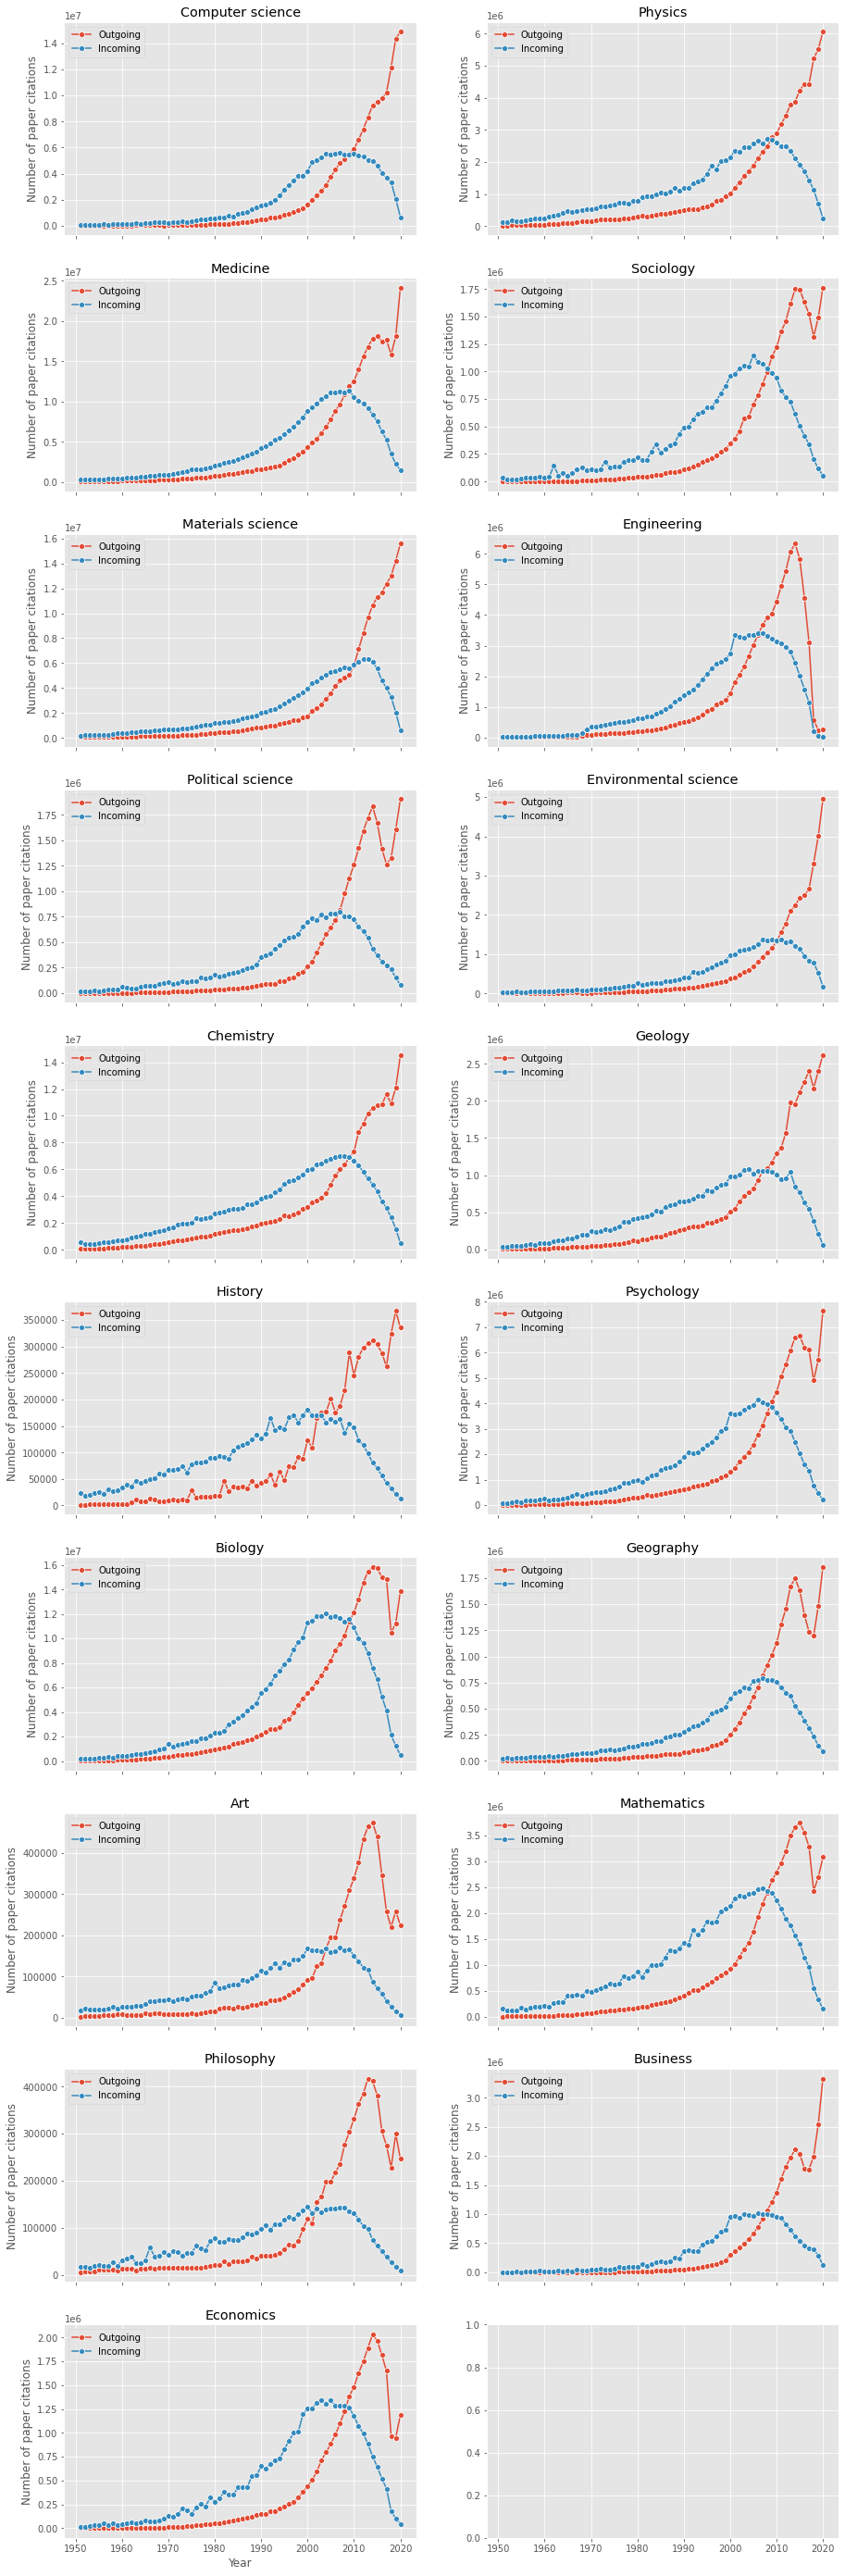

In [13]:
idx = 0
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(15,50), sharex=True)
axs = list(axs.flatten())


for record in fos_df.to_dict('records'):
    
    sns.lineplot(data=discipline_cites_filtered[discipline_cites_filtered.CitingField==record['FieldOfStudyId']], 
                 x='Year', y='NumOutgoingCitations', marker="o", label='Outgoing',
                 palette='cool', ax=axs[idx]).set_title(record['DisplayName'])
    
    sns.lineplot(data=discipline_cites_filtered[discipline_cites_filtered.CitingField==record['FieldOfStudyId']], 
                 x='Year', y='NumIncomingCitations', marker="o", label='Incoming',
                 palette='cool', ax=axs[idx]).set_title(record['DisplayName'])
    
    axs[idx].set_ylabel('Number of paper citations')
    
    idx += 1

In [75]:
def gender_per_country_per_year(mag):

    author_affiliations_gendered = mag.getDataframe('PaperAuthorAffiliationsGendered')
    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    paper_root_field = mag.getDataframe('PaperRootFieldMag')
    papers = mag.getDataframe('Papers')
    
    query = """
    SELECT 
    YEAR(p.Date), ac.CountryCode, paag.Gender, COUNT(paa.PaperId) as Authorships
    FROM PaperAuthorAffiliationsGendered paag 
    INNER JOIN Papers p ON paag.PaperId = p.PaperId
    INNER JOIN PaperAuthorAffiliations paa ON paag.AuthorId = paa.AuthorId AND paag.PaperId = paa.PaperId
    INNER JOIN PaperRootFieldMag prf ON paag.PaperId = prf.PaperId
    GROUP BY YEAR(p.Date), paag.Gender, ac.CountryCode
    """
    gender_per_discipline = mag.query_sql(query)
    return gender_per_discipline

In [7]:
gender_country_per_year = gender_per_country_per_year(mag)

In [8]:
gender_country_per_year_df = gender_country_per_year.toPandas()

In [9]:
def author_papers_per_year(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('WosToMag')
    paper_root_field = mag.getDataframe('PaperRootField')
    # author_country = mag.getDataframe('AuthorCountry')
    papers = mag.getDataframe('Papers')
    
    query = """
    SELECT 
    YEAR(p.Date), paa.AuthorId, COUNT(DISTINCT(paa.PaperId)) as NumPapers
    FROM PaperAuthorAffiliations paa 
    INNER JOIN WosToMag wtm ON paa.AuthorId = wtm.MAG
    INNER JOIN Papers p ON paa.PaperId = p.PaperId
    WHERE wtm.Gender IN (0, 1)
    GROUP BY YEAR(p.Date), paa.AuthorId
    """
    pubs_per_year = mag.query_sql(query)
    return pubs_per_year

In [10]:
pubs_per_year = author_papers_per_year(mag)

In [11]:
pubs_per_year.show(35)

+----------+----------+---------+
|year(Date)|  AuthorId|NumPapers|
+----------+----------+---------+
|      2014|2161718200|        3|
|      2014|2489611286|        1|
|      2007|2705495189|        1|
|      1993|2585487612|        7|
|      1993|2056450520|        9|
|      2006|2060097429|        3|
|      2003|2009447725|        1|
|      1998|2134418757|        1|
|      2010|1672876278|        1|
|      1996|2228693780|        4|
|      1989|2700928155|        1|
|      2006|1794687287|       10|
|      2000|2076266424|       26|
|      2008|2156282726|        4|
|      2015|1889410922|       10|
|      2009|2319855747|        5|
|      2000|2109192206|        3|
|      1998|2160973584|        6|
|      1990|2130793380|        2|
|      2013|2158572959|        2|
|      2012|1039421866|        4|
|      1998|2630127522|        1|
|      2009|2001100636|        4|
|      1991|2226204700|        3|
|      1992|2513438065|        5|
|      2008|2121420673|        1|
|      2014|24

In [12]:
pubs_per_year.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/PapersPerAuthorPerYear.txt")

In [6]:
def authors_per_paper(mag):
    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('WosToMag')
    
    query = """
        SELECT PaperId, 
        COUNT(DISTINCT(AuthorId)) as NumAuthors, 
        (1 / COUNT(DISTINCT(AuthorId))) as Weight,
        COUNT(DISTINCT(wtm.MAG)) as NumMagGendered
        FROM PaperAuthorAffiliations paa
        LEFT JOIN WosToMag AS wtm ON paa.AuthorId = wtm.MAG  
        WHERE wtm.Gender is null or wtm.Gender in (0, 1)
        GROUP BY PaperId
    """
    
    author_paper_stats = mag.query_sql(query)
    return author_paper_stats

In [7]:
author_paper_stats = authors_per_paper(mag)

In [8]:
author_paper_stats.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/AuthorsPerPaper.txt")

In [6]:
def get_weighted_citations(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors_per_paper = mag.getDataframe('AuthorsPerPaper')  
    authors = mag.getDataframe('WosToMag')
    paper_references = mag.getDataframe('PaperReferences')
    
    
    # citations = mag.getDataframe('Citations')
    
    query = """
        SELECT 
          paa1.AuthorId AS CitingAuthorId, 
          pr.PaperId AS CitingPaperId, 
          wtm1.Gender as CitingAuthorGender,
          paa2.AuthorId as CitedAuthorId,
          pr.PaperReferenceId as CitedPaperId,
          wtm2.Gender as CitedAuthorGender,
          (app1.Weight * app2.Weight) as CitationWeight
        FROM PaperAuthorAffiliations AS paa1 
        INNER JOIN PaperReferences pr ON paa1.PaperId = pr.PaperId
        INNER JOIN PaperAuthorAffiliations AS paa2 ON pr.PaperReferenceId = paa2.PaperId 
        INNER JOIN WosToMag AS wtm1 ON paa1.AuthorId = wtm1.MAG 
        INNER JOIN WosToMag AS wtm2 ON paa2.AuthorId = wtm2.MAG 
        INNER JOIN AuthorsPerPaper AS app1 ON paa1.PaperId = app1.PaperId 
        INNER JOIN AuthorsPerPaper AS app2 ON pr.PaperReferenceId = app2.PaperId 
        WHERE wtm1.Gender IN (0, 1) AND wtm2.Gender IN (0, 1)
    """    
    
    weighted_citations = mag.query_sql(query)
    return weighted_citations

In [5]:
def paper_author_affiliation(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    # authors_per_paper = mag.getDataframe('AuthorsPerPaper')  
    authors = mag.getDataframe('WosToMag')
    
    query = """
        SELECT PaperId, AuthorId, 
        CASE WHEN wtm.Gender in (0, 1) THEN wtm.Gender ELSE -1 END as Gender
        FROM PaperAuthorAffiliations paa
        LEFT JOIN WosToMag wtm ON paa.AuthorId = wtm.MAG
        WHERE PaperId IN (
            SELECT DISTINCT(PaperId) 
            FROM PaperAuthorAffiliations paa1 
            INNER JOIN WosToMag wtm1 ON paa1.AuthorId = wtm1.MAG
            WHERE wtm1.Gender in (0, 1)
        )
    """

    paa_new = mag.query_sql(query)
    return paa_new


In [ ]:
paa_new = paper_author_affiliation(mag)
paa_new.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/PaperAuthorAffiliationsGendered.txt")

In [5]:
def get_paper_references_genderes(mag):
    author_affiliations = mag.getDataframe('PaperAuthorAffiliationsGendered')
    paper_references = mag.getDataframe('PaperReferences')
    
    
    query = "SELECT DISTINCT(PaperId) FROM PaperAuthorAffiliationsGendered"
    mag.query_sql(query).createOrReplaceTempView('DistinctPapers')
    
    query = """
        SELECT pr.PaperId, pr.PaperReferenceId 
        FROM PaperReferences pr 
        WHERE pr.PaperId IN (SELECT * FROM DistinctPapers)
        AND pr.PaperReferenceId IN (SELECT * FROM DistinctPapers)
    """
    
    paper_ref_gendered = mag.query_sql(query)
    
    return paper_ref_gendered

In [6]:
paper_ref_gendered = get_paper_references_genderes(mag)

In [7]:
paper_ref_gendered.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/PaperReferencesGendered.txt")

In [9]:
def get_citations_gendered_from_unknown(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliationsGendered')
    # authors_per_paper = mag.getDataframe('AuthorsPerPaper')  
    paper_references = mag.getDataframe('PaperReferencesGendered')    
    
    query = """
        SELECT 
          paa1.AuthorId AS CitingAuthorId, 
          pr.PaperId AS CitingPaperId, 
          paa1.Gender as CitingAuthorGender,
          paa2.AuthorId as CitedAuthorId,
          pr.PaperReferenceId as CitedPaperId,
          paa2.Gender as CitedAuthorGender
        FROM PaperAuthorAffiliationsGendered AS paa1 
        INNER JOIN PaperReferencesGendered pr ON paa1.PaperId = pr.PaperId
        INNER JOIN PaperAuthorAffiliationsGendered AS paa2 ON pr.PaperReferenceId = paa2.PaperId
        WHERE paa1.Gender = -1 
    """    
    
    weighted_citations = mag.query_sql(query)
    return weighted_citations

In [ ]:
weighted_citations = get_citations_gendered_from_unknown(mag)
weighted_citations.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/CitationsFromUnknownGender.txt")

In [11]:
def get_citations_gendered_to_unknown(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliationsGendered')
    # authors_per_paper = mag.getDataframe('AuthorsPerPaper')  
    paper_references = mag.getDataframe('PaperReferencesGendered')    
    
    query = """
        SELECT 
          paa1.AuthorId AS CitingAuthorId, 
          pr.PaperId AS CitingPaperId, 
          paa1.Gender as CitingAuthorGender,
          paa2.AuthorId as CitedAuthorId,
          pr.PaperReferenceId as CitedPaperId,
          paa2.Gender as CitedAuthorGender
        FROM PaperAuthorAffiliationsGendered AS paa1 
        INNER JOIN PaperReferencesGendered pr ON paa1.PaperId = pr.PaperId
        INNER JOIN PaperAuthorAffiliationsGendered AS paa2 ON pr.PaperReferenceId = paa2.PaperId
        WHERE paa2.Gender = -1 and paa1.Gender IN (0, 1)
    """    
    
    weighted_citations = mag.query_sql(query)
    return weighted_citations

In [13]:
citations_to_unknown = get_citations_gendered_to_unknown(mag)

In [14]:
citations_to_unknown.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/CitationsToUnknownGender.txt")

In [9]:
def get_author_author_network(mag, paper_field_id):
    
    citations =  mag.getDataframe('Citations')
    citations_to_unknown = mag.getDataframe('CitationsFromUnknownGender')
    citations_from_unknown = mag.getDataframe('CitationsToUnknownGender')
    
    all_citations = mag.query_sql("""
        SELECT * FROM Citations
        UNION ALL
        SELECT * FROM CitationsFromUnknownGender
        UNION ALL 
        SELECT * FROM CitationsToUnknownGender
    """).createOrReplaceTempView('AllCitations')

    author_affiliations = mag.getDataframe('PaperAuthorAffiliationsGendered')
    paper_root_field = mag.getDataframe('PaperRootFieldMag')
    
     
    query = """
        SELECT
        PaperId, 
        COUNT(DISTINCT(AuthorId)) as NumAuthors
        FROM PaperAuthorAffiliationsGendered
        GROUP BY PaperId
    """
    
    authors_per_paper = mag.query_sql(query)
    authors_per_paper.createOrReplaceTempView('AuthorsPerPaper')

    query = """
        SELECT 
          CitingAuthorId, 
          CitedAuthorId, 
          COUNT(DISTINCT(CitingPaperId)) as numCitingPapers,
          COUNT(DISTINCT(CitedPaperId)) as numCitedPapers,
          SUM( 1 / (app1.NumAuthors * app2.NumAuthors)  ) as Weight
        FROM AllCitations AS ac
        INNER JOIN AuthorsPerPaper app1 ON ac.CitingPaperId = app1.PaperId
        INNER JOIN AuthorsPerPaper app2 ON ac.CitedPaperId = app2.PaperId 
        INNER JOIN PaperRootFieldMag prf1 ON ac.CitingPaperId = prf1.PaperId
        INNER JOIN PaperRootFieldMag prf2 ON ac.CitedPaperId = prf2.PaperId
        WHERE prf1.FieldOfStudyId = {} AND prf2.FieldOfStudyId = {}
        GROUP BY CitingAuthorId, CitedAuthorId
    """.format(paper_field_id, paper_field_id)    
    
    author_edgelist = mag.query_sql(query)
    
    return author_edgelist

In [10]:
# history 95457728
author_edgelist = get_author_author_network(mag, 95457728)

In [ ]:
author_edgelist.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/CitationsHistory.txt")